In [11]:
using Revise
using Plots
using OSQP
using Ipopt
using ForwardDiff

In [2]:
function contact_constraints(h, M, G, C, q0, v0, λ0)
    num_q = length(q0)
    num_v = length(v0)
    num_x = num_q + num_v + 1
    num_g = num_q + num_v + 1  
    
    function eval_g(x, g)
        q = x[1:num_q]
        v = x[num_q+1:num_q+num_v]
        λ = x[num_q+num_v+1]
        
        ϕ = C' * q 
        
        g[1:num_q] = M * (v - v0) .- h * λ * C .- h * M * G
        g[num_q+1:num_q+num_v] = q .- q0 .- h .* v
        g[num_q+num_v+1] = λ + ϕ - sqrt(λ^2 + ϕ^2)
    end
    
    function eval_jac_g(x, mode, rows, cols, values)
        if mode == :Structure
            # for now just assume dense jac
            for i = 1:num_g
                for j = 1:num_x
                    rows[(i-1)*num_x+j] = i
                    cols[(i-1)*num_x+j] = j
                end
            end
        else
            g = zeros(num_q+num_v+1)
            J = ForwardDiff.jacobian((g̃, x̃) -> eval_g(x̃, g̃), g, x)
            values[:] = J'[:]
        end
    end
    
    return eval_g, eval_jac_g
end

function newton_contact_forces(Δt,M,G,C,q0,v0,λ0,qn,vn)
    x = [λ0]
    λ = 1.
    μ = 1.
    c = .01
    
    # manipulator eq in the objective
    # q = -2.*(M*(vn[2] - v0[2])/Δt - M*G[2])
    # f = x -> x' * x + q * x
    # h = x -> (C' * qn) .* x
    
    # complementarity in the objective
    f = x -> ((C' * qn) .* x)'*((C' * qn) .* x)
    h = x -> M*(vn[2] - v0[2]) - Δt*x - Δt*M*G[2]
    
    g = x -> -x
    gp = (x,μ,c) -> max.(g(x), [-μ/c])

    L = (x,λ,μ,c) -> (f(x) + λ*h(x) + .5*c*h(x)'*h(x) + 1./(2.*c)*(max.([0.],μ+c*g(x))'*max.([0.],μ+c*g(x)) - μ^2))[1]
    ∇xL = (x,λ,μ,c) -> ForwardDiff.gradient(x̃ -> L(x̃,λ,μ,c),x)
    HxL = (x,λ,μ,c) -> ForwardDiff.jacobian(x̃ -> ∇xL(x̃,λ,μ,c),x)
    
    N = 6
    α = 1.
    I = 1e-10
    
    for i = 1:N
        gL = ∇xL(x,λ,μ,c)
        HL = HxL(x,λ,μ,c)
        
        dx = (HL + I) \ gL
        x = x - α^i .* dx
        
        λ = λ + c * h(x)[1]
        μ = μ + c * gp(x,μ,c)[1]
        
        c = 2. * c
    end
    
    x[1]
end

function dnewton_contact_forces(h,M,G,C,q0,v0,λ0,qn,vn)
    num_q = length(q0)
    num_v = length(v0)
    
    dλn = ForwardDiff.gradient(x̃ -> newton_contact_forces(h,M,G,C,q0,v0,λ0,x̃[1:num_q],x̃[num_q+1:num_q+num_v]),vcat(qn,vn))

    dλn
end

function contact_forces(h,M,G,C,q0,v0,qn,vn)
    Q = sparse([1],[1],2.)
    q = [-2.*(M*(vn[2] - v0[2])/h - M*G[2])]
    A = sparse([1,2], [1,1], [1.,C'*qn])
    l = [0., 0.]
    u = [1e12, 0.]
    
    m = OSQP.Model()
    OSQP.setup!(m; P=Q, q=q, A=A, l=l, u=u)
    results = OSQP.solve!(m)
    
    results.x, results.y
end

function dcontact_forces(hn,M,G,C,q0,v0,qn,vn,F,Fy)    
    # using the KKT conditions to provide a gradient        
    Q = sparse([1],[1],2.)
    q = [-2.*(M*(vn[2] - v0[2])/hn - M*G[2])]
    
    G = [-1.]
    h = [0.]
    
    A = [qn[2]]
    b = [0.]
    
    K = vcat(hcat(Q,G',A'),
             hcat(diagm(Fy[1])*G,diagm(G*F[1]-h),0.),
             hcat(A,0.,0.))
        
    vdQ = [-F[1],0.,0.]
    vdq = [-1.,0.,0.]
    vdA = [-Fy[2]',0.,-F[1]]
    vdb = [0.,0.,1.]
    vdG = [-Fy[1],-Fy[1]*F[1],0.]
    vdh = [0.,Fy[1],0.]
    
    # dzdQ = (K \ vdQ)[1]
    dzdq = 1.
    # try dzdq = (K \ vdq)[1]
    dzdA = 1.
    # try dzdA = (K \ vdA)[1]
    # dzdb = (K \ vdb)[1]
    # dzdG = (K \ vdG)[1]
    # dzdh = (K \ vdh)[1]
    
    # dQdqn = [0.,0.]
    # dqdqn = [0.,0.]
    dAdqn = [0.,1.]
    # dbdqn = [0.,0.]
    # dGdqn = [0.,0.]
    # dhdqn = [0.,0.]
    
    # dQdvn = [0.,0.]
    dqdvn = [0.,-2.*M/hn]
    # dAdvn = [0.,0.]
    # dbdvn = [0.,0.]
    # dGdvn = [0.,0.]
    # dhdvn = [0.,0.]
    
    # dzdqn = dzdQ*dQdqn + dzdq*dqdqn + dzdA*dAdqn + dzdb*dbdqn + dzdG*dGdqn + dzdh*dhdqn
    # dzdvn = dzdQ*dQdvn + dzdq*dqdvn + dzdA*dAdvn + dzdb*dbdvn + dzdG*dGdvn + dzdh*dhdvn
    
    dzdqn = dzdA*dAdqn
    dzdvn = dzdq*dqdvn
    
    dcontact = hcat(dzdqn,dzdvn)

    dcontact
end

function contact_constraints_implicit(h, M, G, C, q0, v0, λ0)
    num_q = length(q0)
    num_v = length(v0)
    num_x = num_q + num_v
    num_g = num_x + 1

    function eval_g(x, g)
        q = x[1:num_q]
        v = x[num_q+1:end]
        
        # F,Fy = contact_forces(h,M,G,C,q0,v0,q,v)
        F = [newton_contact_forces(h,M,G,C,q0,v0,λ0,q,v)]
        
        g[1:num_v] = M * (v - v0) .- h * F[1] .* C .- h * M .* G
        g[num_v+1:num_v+num_q] = q .- q0 .- h .* v
        g[num_v+num_q+1] = C' * q # ϕ >= 0
    end
    
    function eval_jac_g(x, mode, rows, cols, values)
        if mode == :Structure
            # for now just assume dense jac
            for i = 1:num_g
                for j = 1:num_x
                    rows[(i-1)*num_x+j] = i
                    cols[(i-1)*num_x+j] = j
                end
            end
        else
            # g = zeros(num_g)
            # J = ForwardDiff.jacobian((g̃, x̃) -> eval_g(x̃, g̃), g, x)
            # values[:] = J'[:]
            
            q = x[1:num_q]
            v = x[num_q+1:end]
            # F,Fy = contact_forces(h,M,G,C,q0,v0,q,v) # should be caching this
            # dF = dcontact_forces(h,M,G,C,q0,v0,q,v,F,Fy)
            dF = dnewton_contact_forces(h,M,G,C,q0,v0,λ0,q,v)
            
            values[1] = 0.
            values[2] = 0.
            values[3] = M
            values[4] = 0.
            values[5] = -h * dF[1]
            values[6] = -h * dF[2]
            values[7] = -h * dF[3]
            values[8] = M - h * dF[4]
            values[9] = 1.
            values[10] = 0.
            values[11] = - h
            values[12] = 0.
            values[13] = 0.
            values[14] = 1.
            values[15] = 0.
            values[16] = - h
            values[17] = 0.
            values[18] = 1.
            values[19] = 0.
            values[20] = 0.
        end
    end
    
    return eval_g, eval_jac_g
end

function simulate(h, M, G, C, q0, v0, N)
    results = vcat(q0,v0,0.)
    num_q = length(q0)
    num_v = length(v0)
    num_x = num_q + num_v + 1
    num_g = num_q + num_v + 1
    
    function eval_f(x)
        return 0.
    end
    function eval_grad_f(x, grad_f)
        grad_f[:] = zeros(num_x)
    end
    
    for i in 1:N
        x_L = -1000. * ones(num_x)
        x_U = 1000. * ones(num_x)
    
        g_L = zeros(num_g)
        g_U = zeros(num_g)
        
        q0 = results[1:num_q,end]
        v0 = results[num_q+1:num_q+num_v,end]
        λ0 = results[num_q+num_v+1,end]
        eval_g, eval_jac_g = contact_constraints(h,M,G,C,q0,v0,λ0)
        
        prob = createProblem(num_x,x_L,x_U,num_g,g_L,g_U,num_x*num_g,0,eval_f,eval_g,eval_grad_f, eval_jac_g)
        
        prob.x = copy(results[:,end])
    
        addOption(prob, "hessian_approximation", "limited-memory")
        
        status = solveProblem(prob)   
        println(Ipopt.ApplicationReturnStatus[status])

        results = hcat(results,prob.x)
    end
    
    results
end

function simulate_implicit(h, M, G, C, q0, v0, N)
    results = vcat(q0,v0,0.)
    num_q = length(q0)
    num_v = length(v0)
    num_x = num_q + num_v
    num_g = num_x + 1
    
    function eval_f(x)
        return 0.
    end
    
    function eval_grad_f(x, grad_f)
        grad_f[:] = zeros(num_x)
    end
    
    for i in 1:N
        x_L = -1e6 * ones(num_x)
        x_U = 1e6 * ones(num_x)
    
        g_L = zeros(num_g)
        g_U = zeros(num_g)
        g_U[num_g] = 1e16
        
        q0 = results[1:num_q,end]
        v0 = results[num_q+1:num_q+num_v,end]
        λ0 = results[num_q+num_v+1,end]
        eval_g, eval_jac_g = contact_constraints_implicit(h,M,G,C,q0,v0,λ0)
        
        prob = createProblem(num_x, x_L, x_U, num_g, g_L, g_U, 
                             num_x*num_g, 0, eval_f, eval_g, eval_grad_f, eval_jac_g)
        
        prob.x = copy(results[1:num_x,end])
        addOption(prob, "hessian_approximation", "limited-memory")
        
        status = solveProblem(prob)
           
        println(Ipopt.ApplicationReturnStatus[status])
    
        qnext = prob.x[1:num_q]
        vnext = prob.x[num_q+1:num_q+num_v]
        λnext = newton_contact_forces(h,M,G,C,q0,v0,λ0,qnext,vnext)
        
        results = hcat(results,vcat(prob.x,λnext))
    end
    
    results
end

simulate_implicit (generic function with 1 method)

In [4]:
h = 0.05 # step size
M = 1.0 # mass
G = [0, -9.81] # gravity
C = [0, 1]; # contact normal

q0 = [-1, 0]
v0 = [0, -1]
λ0 = 0.;

In [9]:
q = [-1, 0]
v = [0, 1.];
println(contact_forces(h,M,G,C,q0,v0,q,v)[1][1])
println(newton_contact_forces(h,M,G,C,q0,v0,λ0,q,v))
println(dnewton_contact_forces(h,M,G,C,q0,v0,λ0,q,v))

49.810000196995645
49.810000000060775
[-0.0, -0.0, -0.0, 20.0]
-----------------------------------------------------------------
           OSQP v0.4.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 1, constraints m = 2
          nnz(P) + nnz(A) = 3
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

iter   objective    pri res    dua res    rho        time
   1  -1.0142e+03   0.00e+00   7.66e+01   1.00e-01   2.50e-05s
  50  -2.4810e+03   0.00e+00   3.94e-07   1.00e-06   4.15e-05s

stat


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       16
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equa

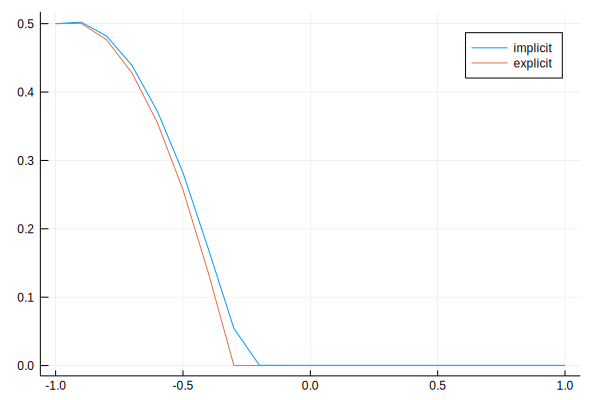

In [12]:
q0 = [-1, 0.5]
v0 = [2, 0.5]
N = 20
results_implicit = simulate_implicit(h, M, G, C, q0, v0, N)
results = simulate(h, M, G, C, q0, v0, N)
plot(results_implicit[1,:],results_implicit[2,:],label="implicit")
plot!(results[1,:],results[2,:],label="explicit")